<a href="https://colab.research.google.com/github/Gaurav7888/RecSys/blob/main/RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/microsoft/recommenders.git

# Data Splits :- 1) Random split 2) chronological Split 3) stratified split

In [ ]:
!pip install pyspark

In [ ]:
import sys
import pyspark
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.datasets.download_utils import maybe_download
from recommenders.datasets.python_splitters import (
    python_random_split,
    python_chrono_split,
    python_stratified_split
)
from recommenders.datasets.spark_splitters import spark_random_split

print(f"System version: {sys.version}")
print(f"Pyspark version: {pyspark.__version__}")

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pyspark version: 3.5.0


In [ ]:
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
DATA_PATH = "ml-100k.data"

COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "Rating"
COL_TIMESTAMP = "Timestamp"

In [ ]:
filepath = maybe_download(DATA_URL, DATA_PATH)


100%|██████████| 1.93k/1.93k [00:00<00:00, 2.67kKB/s]


In [ ]:
data = pd.read_csv(filepath, sep="\t", names=[COL_USER, COL_ITEM, COL_RATING, COL_TIMESTAMP])


In [ ]:
data.head()

,UserId,MovieId,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
data.describe()

,UserId,MovieId,Rating,Timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [ ]:
print(
    "Total number of ratings are\t{}".format(data.shape[0]),
    "Total number of users are\t{}".format(data[COL_USER].nunique()),
    "Total number of items are\t{}".format(data[COL_ITEM].nunique()),
    sep="\n"
)

Total number of ratings are	100000
Total number of users are	943
Total number of items are	1682


In [ ]:
data[COL_TIMESTAMP]= data.apply(
    lambda x: datetime.strftime(datetime(1970, 1, 1, 0, 0, 0) + timedelta(seconds=x[COL_TIMESTAMP].item()), "%Y-%m-%d %H:%M:%S"),
    axis=1
)

In [ ]:
data.head()

,UserId,MovieId,Rating,Timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


#Type of spliting :-
1) Recommender-A is to recommend movies to people by taking people's collaborative rating similarities. To make sure the evaluation is statisically sound, the same set of users for both model building and testing should be used (to avoid any cold-ness of users), and a stratified splitting strategy should be taken.   


2) Recommender-B is to recommend fashion products to customers. It makes sense that evaluation of the recommender considers time-dependency of customer purchases, as apparently, tastes of the customers in fashion items may be drifting over time. In this case, a chronologically splitting should be used.

In [ ]:
data_train, data_test = python_random_split(data, ratio=0.7)

In [ ]:
data_train.shape[0], data_test.shape[0]


(70000, 30000)

In [ ]:
data_train, data_validate, data_test = python_random_split(data, ratio=[0.6, 0.2, 0.2])


In [ ]:
data_train.shape[0], data_validate.shape[0], data_test.shape[0]


(60000, 20000, 20000)

In [ ]:
data_train, data_test = python_chrono_split(
    data, ratio=0.7, filter_by="user",
    col_user=COL_USER, col_item=COL_ITEM, col_timestamp=COL_TIMESTAMP
)

In [ ]:
data_train[data_train[COL_USER] == 1].tail(10)


,UserId,MovieId,Rating,Timestamp
1989,1,90,4,1997-11-03 07:31:40
11807,1,219,1,1997-11-03 07:32:07
50026,1,167,2,1997-11-03 07:33:03
202,1,61,4,1997-11-03 07:33:40
16314,1,230,4,1997-11-03 07:33:40
43280,1,162,4,1997-11-03 07:33:40
51295,1,35,1,1997-11-03 07:33:40
820,1,265,4,1997-11-03 07:34:01
11154,1,112,1,1997-11-03 07:34:01
45732,1,57,5,1997-11-03 07:34:19


In [ ]:
data_train[data_train[COL_USER] == 1].head(10)


,UserId,MovieId,Rating,Timestamp
59972,1,168,5,1997-09-22 21:57:58
92487,1,172,5,1997-09-22 21:57:58
74577,1,165,5,1997-09-22 21:58:38
48214,1,156,4,1997-09-22 21:59:16
15764,1,196,5,1997-09-22 22:01:17
22971,1,166,5,1997-09-22 22:01:17
21626,1,187,4,1997-09-22 22:01:18
9170,1,14,5,1997-09-22 22:01:46
12948,1,250,4,1997-09-22 22:01:46
53552,1,127,5,1997-09-22 22:01:46


In [ ]:
data_train, data_test = python_chrono_split(
    data, filter_by="user", min_rating=10, ratio=0.7,
    col_user=COL_USER, col_item=COL_ITEM, col_timestamp=COL_TIMESTAMP
)

In [ ]:
data_train, data_test = python_stratified_split(
    data, filter_by="user", min_rating=10, ratio=0.7,
    col_user=COL_USER, col_item=COL_ITEM
)


In [ ]:
spark = start_or_get_spark()


In [ ]:
data_spark = spark.read.csv(filepath)


In [ ]:
data_spark_train, data_spark_test = spark_random_split(data_spark, ratio=0.7)


In [ ]:
data_spark_train.count(), data_spark_test.count()


(69941, 30059)

# Data transformation for collaborative filtering

It is usually observed in the real-world datasets that users may have different types of interactions with items.like click a button, view a movie

# only applicable to collaborative filtering algorithms.

In [ ]:
import sys
import pandas as pd
import numpy as np
import datetime
import math

print(f"System version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy version: 1.23.5
Pandas version: 1.5.3


# Explicit Rating
In the "explicit feedback" scenario, interactions between users and items are numerical / ordinal ratings or binary preferences such as like or dislike. These types of interactions are termed as explicit feedback.

In [ ]:
data1 = pd.DataFrame({
    "UserId": [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    "ItemId": [1, 1, 2, 2, 2, 1, 2, 1, 2, 3, 3, 3, 3, 3, 1],
    "Rating": [4, 4, 3, 3, 3, 4, 5, 4, 5, 5, 5, 5, 5, 5, 4],
    "Timestamp": [
        '2000-01-01', '2000-01-01', '2000-01-02', '2000-01-02', '2000-01-02',
        '2000-01-01', '2000-01-01', '2000-01-03', '2000-01-03', '2000-01-03',
        '2000-01-01', '2000-01-03', '2000-01-03', '2000-01-03', '2000-01-04'
    ]
})

In [ ]:
data1.head()

,UserId,ItemId,Rating,Timestamp
0,1,1,4,2000-01-01
1,1,1,4,2000-01-01
2,1,2,3,2000-01-02
3,1,2,3,2000-01-02
4,1,2,3,2000-01-02


# Implicit feedback
the interactions are usually implicit. For example, a user may puchase something on a website, click an item on a mobile app, or order food from a restaurant. This information may reflect users' preference towards the items in an implicit manner.
 click, add and purchase, meaning "click on the item", "add the item into cart" and "purchase the item", respectively.
 Sometimes there is other contextual or associative information available for the types of interactions. E.g., "time-spent on visiting a site before clicking"

In [ ]:
data2 = pd.DataFrame({
    "UserId": [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    "ItemId": [1, 1, 2, 2, 2, 1, 2, 1, 2, 3, 3, 3, 3, 3, 1],
    "Type": [
        'click', 'click', 'click', 'click', 'purchase',
        'click', 'purchase', 'add', 'purchase', 'purchase',
        'click', 'click', 'add', 'purchase', 'click'
    ],
    "Timestamp": [
        '2000-01-01', '2000-01-01', '2000-01-02', '2000-01-02', '2000-01-02',
        '2000-01-01', '2000-01-01', '2000-01-03', '2000-01-03', '2000-01-03',
        '2000-01-01', '2000-01-03', '2000-01-03', '2000-01-03', '2000-01-04'
    ]
})

In [ ]:
data2.head()

,UserId,ItemId,Type,Timestamp
0,1,1,click,2000-01-01
1,1,1,click,2000-01-01
2,1,2,click,2000-01-02
3,1,2,click,2000-01-02
4,1,2,purchase,2000-01-02


In [ ]:
data1 = data1.drop_duplicates()


In [ ]:
data2_count = data2.groupby(['UserId', 'ItemId']).agg({'Timestamp': 'count'}).reset_index()
data2_count.columns = ['UserId', 'ItemId', 'Affinity']

In [ ]:
data2_count.head()


,UserId,ItemId,Affinity
0,1,1,2
1,1,2,3
2,2,1,2
3,2,2,2
4,2,3,1


In [ ]:
# Add column of weights
data2_w = data2.copy()

conditions = [
    data2_w['Type'] == 'click',
    data2_w['Type'] == 'add',
    data2_w['Type'] == 'purchase'
]

choices = [1, 2, 3]

data2_w['Weight'] = np.select(conditions, choices, default='black')

# Convert to numeric type.
data2_w['Weight'] = pd.to_numeric(data2_w['Weight'])

In [ ]:
data2_wcount = data2_w.groupby(['UserId', 'ItemId'])['Weight'].sum().reset_index()
data2_wcount.columns = ['UserId', 'ItemId', 'Affinity']

In [ ]:
data2_wcount.head()

,UserId,ItemId,Affinity
0,1,1,2
1,1,2,5
2,2,1,3
3,2,2,6
4,2,3,3


# Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs (KGs) as an external source of information

In [ ]:
import logging
logger = logging.getLogger()


import sys
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from recommenders.datasets import movielens
from recommenders.datasets.wikidata import (search_wikidata,
                                         find_wikidata_id,
                                         query_entity_links,
                                         read_linked_entities,
                                         query_entity_description)
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
MOVIELENS_DATA_SIZE = "100k"
MOVIELENS_SAMPLE = True
MOVIELENS_SAMPLE_SIZE = 50

In [ ]:
names = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "", "My Best Friend's Wedding"]


In [ ]:
results_list = []
for idx, name in enumerate(names):
    # first get the wikipedia entity_id for each name
    entity_id = find_wikidata_id(name)
    if entity_id == "entityNotFound":
        continue

    # next we query wikipedia to get entity links
    json_links = query_entity_links(entity_id)

    # the following function extracts entities from the links
    related_links = read_linked_entities(json_links)

    # now we can construct an connection in our graph between two entities
    for related_entity, related_name in related_links:
        result = dict(
            name=name,
            original_entity=entity_id,
            linked_entities=related_entity,
            name_linked_entities=related_name,
        )
        results_list.append(result)

results_list = pd.DataFrame(results_list)
results_list.head()

,name,original_entity,linked_entities,name_linked_entities
0,The Godfather,Q47703,Q377616,New Hollywood
1,The Godfather,Q47703,Q130232,drama film
2,The Godfather,Q47703,Q52207399,film based on a novel
3,The Godfather,Q47703,Q7444356,gangster film
4,The Godfather,Q47703,Q959790,crime film


In [ ]:
G = nx.from_pandas_edgelist(results_list, "original_entity", "linked_entities")


In [ ]:
target_names = results_list[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = results_list[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

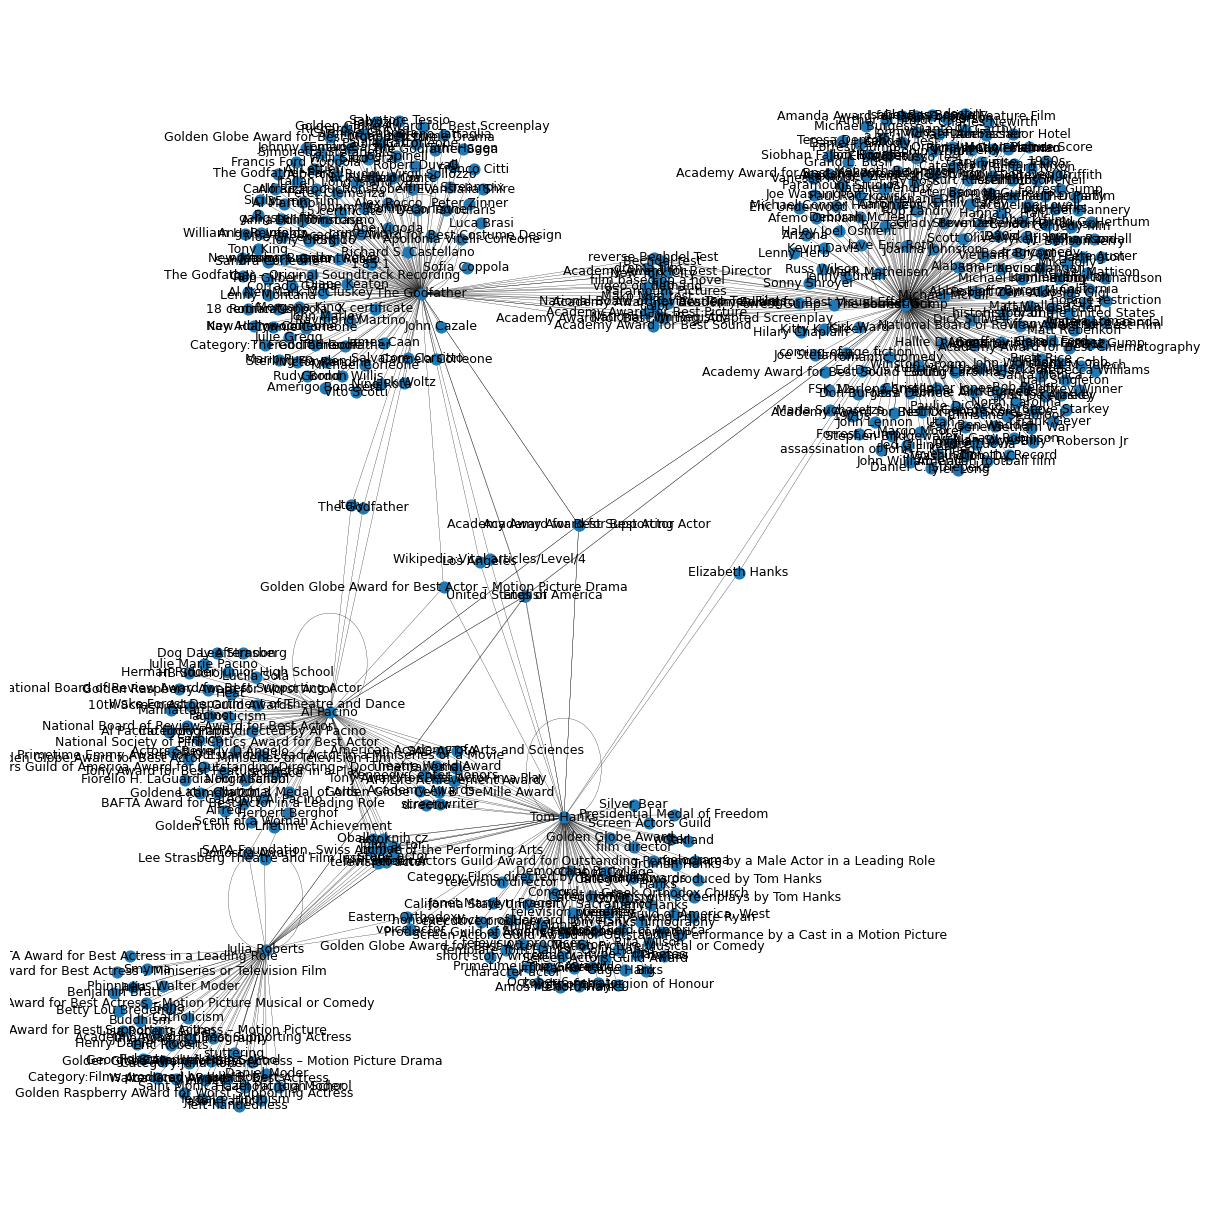

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=60,font_size=9, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.show()

In [ ]:
df = movielens.load_pandas_df(
    MOVIELENS_DATA_SIZE,
    ("UserId", "ItemId", "Rating", "Timestamp"),
    title_col="Title",
    genres_col="Genres",
    year_col="Year",
)
movies = df[["Title", "ItemId"]].drop_duplicates().reset_index()

100%|██████████| 4.81k/4.81k [00:00<00:00, 5.18kKB/s]


In [ ]:
movies["Title"][0:5]


0                  Kolya (1996)
1      L.A. Confidential (1997)
2           Heavyweights (1994)
3    Legends of the Fall (1994)
4           Jackie Brown (1997)
Name: Title, dtype: object

In [ ]:
if MOVIELENS_SAMPLE == True:
    movies = movies.head(MOVIELENS_SAMPLE_SIZE)

In [ ]:
names = [t + " film" for t in movies["Title"]]
result = search_wikidata(names, extras=movies[["Title", "ItemId"]].to_dict())
result.head()

,name,original_entity,linked_entities,name_linked_entities,description,Title,ItemId
0,Kolya (1996) film,Q1141186,Q130232,drama film,1996 film by Jan Svěrák,Kolya (1996),242
1,Kolya (1996) film,Q1141186,Q157443,comedy film,1996 film by Jan Svěrák,Kolya (1996),242
2,Kolya (1996) film,Q1141186,Q100977416,Věra Uzelacová,1996 film by Jan Svěrák,Kolya (1996),242
3,Kolya (1996) film,Q1141186,Q104626218,Luboš Bíža,1996 film by Jan Svěrák,Kolya (1996),242
4,Kolya (1996) film,Q1141186,Q10819887,Andrei Chalimon,1996 film by Jan Svěrák,Kolya (1996),242


In [ ]:
result["Title"].value_counts()


Right Stuff, The (1983)                                    136
Silence of the Lambs, The (1991)                            99
Kolya (1996)                                                96
Hunt for Red October, The (1990)                            96
L.A. Confidential (1997)                                    79
Jaws (1975)                                                 76
Casper (1995)                                               68
Cop Land (1997)                                             62
Remains of the Day, The (1993)                              61
Sabrina (1995)                                              59
Twister (1996)                                              58
Jackie Brown (1997)                                         58
Sleepless in Seattle (1993)                                 57
Kiss the Girls (1997)                                       54
Sabrina (1954)                                              54
Legends of the Fall (1994)                             